 # **Quality control and class noise reduction of satellite image time series**
 
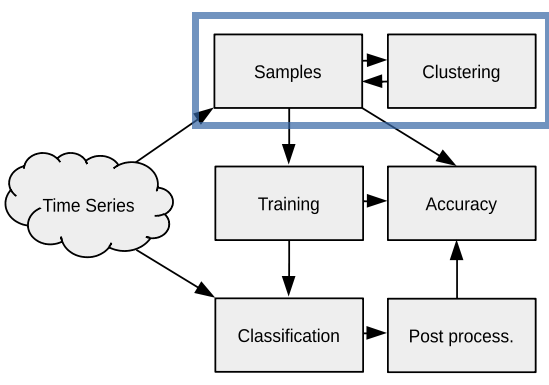

In this hands-on, we organize an activity using sits package to assess remote sensing time series.



In [ ]:
library(tidyverse) 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
list.files(path = "../input")


In [ ]:
library(devtools)

In [ ]:
install_github("rolfsimoes/sits@kaggle", dependencies = FALSE)

In [ ]:
library(sits)

In [ ]:
library(dplyr)

In [ ]:
# Configure plot size 
options(repr.plot.width = 15, repr.plot.height = 6)

# Noisy dataset

In [ ]:
# Loading noisy dataset
input_data.tb <- readRDS("../input/input-dataset/input_data.rds")

In [ ]:
# Returns the information about labels of dataset
sits_labels(input_data.tb)

In [ ]:
print (input_data.tb)

In [ ]:
# Point to be classified - Time series of 16 years
point_to_classify <- sits_select_bands(point_mt_6bands, ndvi, evi, nir, mir)
plot(point_to_classify)

# **Train noisy dataset and classify a time series**

In [ ]:
# Train a machine learning model using Random Forest
model <- sits_train(data = input_data.tb, ml_method = sits_rfor())

# Classify using random forest model and plot the result
class.tb <- sits_classify(point_to_classify, model)

# Show the results of the prediction for each year
sits_show_prediction(class.tb)

Here we can notice an inconsistency in the classification result! It is not possible a year have been classified as Forest followed by Pasture. It happened because the class noise in the input dataset. Samples that should have been labeled as Pasture or some type of crop have been labeled as Forest.

In [ ]:
# Plot the result of the classification
plot(class.tb)

# **Evaluating samples with self-organizing maps (SOM)**

This function uses package Konhonen to find clusters in satellite image time series to cluster the samples. Besides that, this function evaluates the quality of each sample through SOM properties, such as evaluate each sample allocated in aneuron-cluster and its neighbourhood.

The main parameters for this functions are:
(a) input_data.tb - A tibble with samples to be clustered.

(b) Grid size (X,Y).

(c) alpha - Learning rate.

(d) rlen - Number of iterations to converge SOM method.

(e) distance -The type of similarity measure (distance).

(f) iterations - The number of time to run the SOM cluster.

In [ ]:
set.seed(99)
som_clustering <-
  sits::sits_som_map(
    input_data.tb,
    grid_xdim = 8,
    grid_ydim = 8,
    alpha = c(0.05,0.01),
    rlen = 100,
    distance = "euclidean",
    iterations = 1
  )

In [ ]:
print (som_clustering)

The output tibble contains additional columns:
(a) A list of tibbles containing information about each sample, neuron and the overall statistics about the probabilities.
(b) The properties of SOM, such as, size grid, weight of neurons, color of each neuron
(c) The final output. It is a tibble with two more columns besides the coluumns of the input data ( conditional probability and posterior probability)

In [ ]:
plot(som_clustering, type = "codes", whatmap = 1)


In [ ]:
# Get the final probabilities
som_output <- som_clustering$samples_output.tb

# Print  probabilities
print(dplyr::select(som_output, id_sample, label, conditional_prob,posterior_prob))

In [ ]:
# General information about the clusters
cluster_analysis <- sits_som_evaluate_cluster(som_clustering)
plot(cluster_analysis, title = "Cluster purity")


In [ ]:
print(som_output)

# **Remove noisy samples**

The function sits_som_clean_samples removes samples that do not have good quality based on the statistics of the result of the clustering using SOM. It also provides samples that should be analysed.
In this course we will keep that the samples that should be analysed in our dataset. 
When a specialist analyze these samples, he/she might verify spatiotemporal conditions that are not approached in this course.

In [ ]:
# Cleaning dataset throught the probabilities
output_samples.lst <- sits_som_clean_samples(som_clustering, conditonal_threshold = 0.6,posterior_threshold = 0.4)

print(output_samples.lst )

In [ ]:
# Just to check the number of samples that should be analyzed!
samples_to_analyze.tb <- output_samples.lst$make_analysis.tb
table(samples_to_analyze.tb$label)

In [ ]:
# Join the samples that were kept in dataset and the samples that should be analyzed
output_samples.tb <- dplyr::bind_rows(c(output_samples.lst))
print(output_samples.tb)

# **Train new dataset and classify and classify the same time series**

In [ ]:
set.seed(17)

# Train a machine learning model using Random Forest using the new dataset
model_after_som <- sits_train(data = output_samples.tb, ml_method = sits_rfor())

# Classify using random forest model and plot the result
class_output.tb <- sits_classify(point_to_classify, model_after_som)

# show the results of the prediction
sits_show_prediction(class_output.tb)




# **New classification**

In [ ]:
plot(class_output.tb)

# **Explore SOM output**

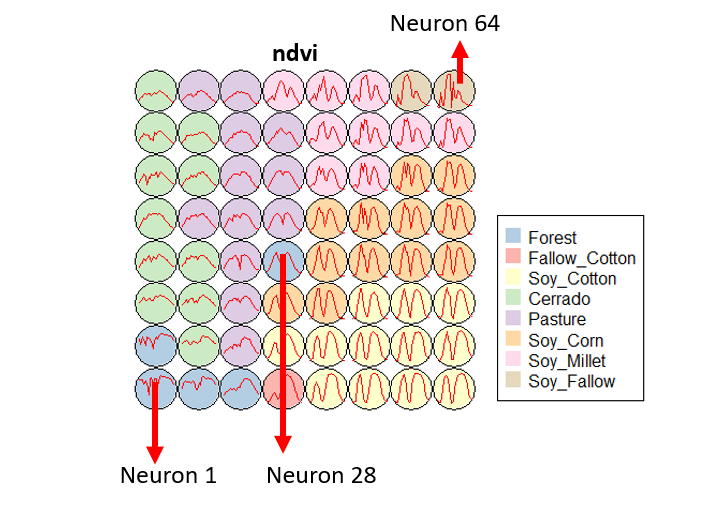

The package sits does not provide ready functions to explore each neuron or samples. However, if you want to handle and explore information each neuron,sample or removed data, you can use tibbles of the output "som_clustering". We suggest use the package dplyr to handle the tibbles.

He are some examples!

In [ ]:
#Print information about samples assigned to a specific neuron
neuron_x <- dplyr::filter((som_clustering$statistics_samples$samples_t), id_neuron == 64)
print(neuron_x)
table (neuron_x$original_label )


In [ ]:
# Here, for each sample we are getting id neuron and label neuron where the sample were assigned
id_neuron_sample <- unique(dplyr::select(som_clustering$statistics_samples$samples_t, id_neuron, id_sample, neuron_label))
head(id_neuron_sample,5)

# Here we are adding the id neuron and the neuron label to som_output
samples_complete <- som_clustering$samples_output.tb %>% inner_join(id_neuron_sample)

# Return information about the neurons and samples assigned to them (summary)
get_info_neurons.tb <- (arrange(unique(select(samples_complete, id_neuron, neuron_label, label, conditional_prob, posterior_prob)), id_neuron))
head(get_info_neurons.tb)

In [ ]:
# Print info about neurons labelled as "Forest"
dplyr::filter(get_info_neurons.tb, neuron_label == "Forest" & label == "Forest")

In [ ]:
# Removed samples labelled as Forest
subset_removed_samples <- (dplyr::filter(samples_complete, label == "Forest" & conditional_prob < 0.6 ))
print(dplyr::select(subset_removed_samples, id_sample, label,id_neuron, neuron_label, conditional_prob,posterior_prob ))

In [ ]:
plot(dplyr::filter(samples_complete, id_sample == 235))

In [ ]:
# Print info about neurons labelled as "Fallow_Cotton"
dplyr::filter(get_info_neurons.tb, neuron_label == "Fallow_Cotton" & label == "Fallow_Cotton")

In [ ]:
# Print only information about Fallow Cotton
dplyr::filter(get_info_neurons.tb, neuron_label == "Fallow_Cotton" & label == "Fallow_Cotton")

# Print information about all samples that were assigned to neurons labelled as Fallow Cotton
dplyr::filter(get_info_neurons.tb, neuron_label == "Fallow_Cotton")

**Explore SOM properties**

In [ ]:
# Get weight vectors of each neuron

som_clustering$som_properties$codes